In [5]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq


EPOINT = 0
np.seterr(invalid='ignore')
plt.rcParams.update({'font.size': 20})
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

# A collection of functions

In [11]:
def getSize(file):
    '''Returning the number of KICs in a targettext file.

    Parameters
    ----------
    file : string
        The path to the file containing the list of KICs.


    Returns
    -------
    getsize.size : integer
        The number of KICs in the file.
    '''
    temp = pd.read_table(file, names=['kic'])
    getsize = temp['kic'].values
    return getsize.size



def calcChiSq(data, fit, errList):
    '''Caclulate the Chi-Squared value between a fit and the raw data

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    fit : array
        An array of the fit data

    errList : array
        An array of the error in each fit


    Returns
    -------
    chiSq : float
        the calculated Chi-Square Value
    '''
    chiSq = np.sum(((data - fit) / errList)**2.0)/np.size(data)
    return chiSq




def calcError(data, multiple):
    '''Calculating the asymmetric error bar for each data point

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    multiple : integer
        The total duration (in days) of each quarter, so that we can get turn the data
        from a #/day unit to a total #, allowing for error bar calculation


    Returns
    -------
    errUp : float
        the upper error bar

    errDn : flaot
        the lower error bar
    '''
    data = data*multiple
    errDn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    errUp = (np.sqrt(data + 0.75) + 1.0)/multiple
    return errUp, errDn



def calcBic(size, degree, chiSq):
    '''Using the Bayesian Information Criterion calculation

    Parameters
    ----------
    size : integer
        The number of data points.
    degree: integer
        The degree of the polynomial fit.
    chiSq : float
        Chi-Squared value.


    Returns
    -------
    bic : float
        the Bayesian Information Criterion Value
    '''
    bic = chiSq + ((degree+1) * np.log(size))
    return bic




def fitDegreeK(xaxis, yaxis, errList, degree, size):
    '''Fitting a polynomial of degree K

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The data's associted error bars.

    degree : integer
        The degree of the polynomial to be fit.

    size : integer
        The number of data points.


    Returns
    -------
    bic : float
        The Bayesian Information Criterion value.

    fit : array
        An array containing the best fit of degree k.

    parameters : array
        Coefficients for the fit.

    covariance : matrix (array)
        The covariance matric associated w/ the fit.

    chiSq : float
        The Chi-Squared value.
    '''
    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False)

    fit = np.polyval(parameters, xaxis)
    chiSq = calcChiSq(yaxis, fit, errList)
    bic = calcBic(size, degree, chiSq)
    return bic, fit, parameters, covariance, chiSq




def updateArray(exportArray, targetIndex, KIC, size, degree, bestParameters, bestChiSquare, bestCov):
    '''Updating an array that contain all of the relevant fit data

    Parameters
    ----------
    exportArray : array
        The array that will be updated.

    targetIndex : integer
        The index that keeps track of which KIC we're on.

    KIC : string
        The KIC who's data is getting sent to the array.

    size : integer
        Number of data points.

    degree : interger
        The degree of the fit.

    bestParameters : array
        The coefficients of the best fit polynomial.

    bestChiSquare : float
        The Chi-Square of the best fit.

    bestCov : array
        The covariance matrix of the best-fit, returned by polyfit.


    Returns
    -------
    exportArray : array
        The array being updated with the fit data, which will eventually be exported (written) to a file
    '''
    exportArray[targetIndex, 0] = KIC
    exportArray[targetIndex, 1] = size
    exportArray[targetIndex,2] = degree
    exportArray[targetIndex, 3] = '{}'.format('%.4f'%bestChiSquare)
    length = len(bestParameters)

    for x in range(length):
        exportArray[targetIndex, (8-length+x)] = '{}'.format('%.4f'%bestParameters[x])
        exportArray[targetIndex, (12-length+x)] = '{}'.format('%.4f'%(np.sqrt(bestCov[x,x])))
    return exportArray





def plotEVF(KIC, files, fileCount, **kwargs):
    '''Plotting the energy versus frequency for the KIC data

    Parameters
    ----------
    KIC : string
        The KIC being evaluated.

    files : string
        A glob of all of the .flare files, containing the quarters for each KIC.

    fileCount : integer
        The number of files.

    **kwargs
        Show : If True, shows the plots.
        ShowMean : If True, shows the plot associated with subtracting the fit from the mean of each quarter.
        Whole : If True, displays the entire EVF plot, rather than just the plot above the ok68 cutoff.
        Error : If True, shows the error bars on the plot.
    '''
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y (" + str(KIC) + ')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy")
    plt.yscale('log')
    errListUp = np.array([])
    errListDn = np.array([])
    totalEVFFitX = np.array([])
    totalEVFFitY = np.array([])
    quarterlyMean = np.array([])
    time = np.array([])


    for x in range(fileCount):
        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array
        ffdXEnergy = np.log10((energy + EPOINT)[sort][::-1])#log the reverse of sorted energy
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = (ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT)
        totalEVFFitX = np.append(totalEVFFitX, ffdXEnergy[ok68])
        totalEVFFitY = np.append(totalEVFFitY, ffdYFrequency[ok68])
        quarterlyMean = np.append(quarterlyMean, np.mean(ffdYFrequency[ok68]))
        time = np.append(time, np.sum(df['t_start'])/len(df['t_start'])) #finding the mean time for a file

        if(kwargs['whole']==True):  #plotting all data
            plt.plot(ffdXEnergy, ffdYFrequency, lw = 1, c = cmap(x/float(fileCount)))

            if(kwargs['error']==True):
                errUp, errDn = calcError(ffdYFrequency, toteDuration)
                plt.errorbar(ffdXEnergy, ffdYFrequency, yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

        else: #use ED68i to get indices of useful data, ignore the junk
            plt.plot(ffdXEnergy[ok68], ffdYFrequency[ok68], lw = 1, c = cmap(x/float(len(files))))

            if(kwargs['error']==True):
                errUp, errDn = calcError(ffdYFrequency[ok68], toteDuration)
                plt.errorbar(ffdXEnergy[ok68], ffdYFrequency[ok68], yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)


    parameters, covariance = np.polyfit(totalEVFFitX, totalEVFFitY, 1, cov=True, full =False)
    fit = np.polyval(parameters, totalEVFFitX)
    #plt.plot(totalEVFFitX, fit, c="red")
    #plt.savefig('energy_vs_frequency_plot/'+ str(KIC) + '_whole_FFD.png')
    if(kwargs['show']==True):
        plt.show()
    plt.close()

    plt.figure(figsize=(9,7))
    plt.title("Time vs FFD_Y Mean Difference (" + str(KIC) + ')')
    plt.ylabel("quarterlyMean - totalMean")
    plt.xlabel("Time (days)")
    meanFit = np.mean(fit)
    meanDifference = quarterlyMean - meanFit
    plt.plot(time,meanDifference, c="red")
    #plt.savefig('time_vs_mean_difference/'+ str(KIC) + '.png')
    if(kwargs['showMean']==True):
        plt.show()
    plt.close()





def plotTVF(KIC, files, fileCount, exportArray, fixedEnergy, targetIndex, **kwargs):
    '''Plotting the time versus frequency for the KIC data

    Parameters
    ----------
    KIC : string
        The KIC being evaluated.

    files : string
        A glob of all of the .flare files, containing the quarters for each KIC.

    fileCount : integer
        The number of files.

    exportArray : array
        The array that gets updated with the fit data

    fixedEnergy : float
        The energy that being used to interpolate the frequency from each quarters EVF curve

    targetIndex : integer
        An index that keeps track of where the exportArray should be updated

    **kwargs
        Show : If True, shows the plots.
    '''
    plt.figure(figsize=(9,7))
    plt.title("Time vs Frequency (KIC "+str(KIC)+', E = '+str(fixedEnergy)+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Time (days)")
    plt.yscale('log')
    xaxis = np.array([])
    yaxis = np.array([])
    errListUp = np.array([])
    errListDn = np.array([])

    #loop over each .flare file
    for x in range(fileCount):
        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get inp.wherendices that would sort the energy array
        ffdXEnergy = (np.log10(energy) + EPOINT)[sort][::-1] #log the reverse of sorted energy
        ffdXEnergy = ffdXEnergy[np.isfinite(ffdXEnergy)]
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        if(np.amax(ffdXEnergy) >= fixedEnergy >= np.amin(ffdXEnergy)): #checking that the energy constant isn't out of bound,otherwise, interpolate doesn't work

            meanStart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file
            ffdYAtEnergy = np.interp(fixedEnergy, ffdXEnergy[::-1], ffdYFrequency[::-1])#interpolating the ffd_y
            xaxis = np.append(xaxis, meanStart) #making lists so we can fit a line later
            yaxis = np.append(yaxis, ffdYAtEnergy)

            errUp, errDn = calcError(ffdYAtEnergy, toteDuration)#dealing w/ error
            errListUp = np.append(errListUp, errUp)
            errListDn = np.append(errListDn, errDn)
            #plt.errorbar(meanStart, ffdYAtEnergy, yerr = [[errDn],[errUp]], fmt='o', c = cmap(x/float(len(files))) ,markersize=4, elinewidth=1,capsize=6)#plotting error

    bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size = compareFits(xaxis, yaxis, errListUp)
    exportArray = updateArray(exportArray, targetIndex, KIC, size, bestFitDegree, bestParameters, bestChiSquare, bestCovariance)
    plt.plot(xaxis, bestFit, 'red', lw=1)
    plt.errorbar(xaxis, yaxis, yerr = [errListDn,errListUp], fmt='o', color= 'black',markersize=4, elinewidth=1,capsize=6)#plotting error
    #plt.annotate('Degree Of Fit = {}\nChi-Square = {}'.format(bestFitDegree, '%.3f'%(bestChiSquare)), xy=(250, 0.1),size=16, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    #plt.savefig('time_vs_frequency_plot/'+str(KIC)+'_vs_time_E='+str(fixedEnergy)+'.png')
    if(kwargs['show']==True):
        plt.show()
    plt.close()




def compareFits(xaxis, yaxis, errList):
    '''Comparing two fits, and determining which fit is the 'best' based on the Bayseian information criterion

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The error associated with each point

    Returns
    -------
    bestFit : array
        The data from the best fit polynomial.

    bestParameters : array
        The coefficients of polynomial being used to fit the data.

    bestCovariance : array
        A covariance matrix of the bestfit, returned by polyfit

    bestChiSquare : float
        The Chi-Square of the best fit

    bestFitDegree : integer
        The degree of the polynomial being used to fit the data.

    size: integer
        The number of data points in the fit
    '''
    size = np.size(xaxis)
    bestFitDegree = 0
    bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = fitDegreeK(xaxis, yaxis, errList, bestFitDegree, size)
    degree = 1

    while(degree<4):
        try:
            bic2, fit, parameters, covariance, chiSquare = fitDegreeK(xaxis, yaxis, errList, degree, size)
        except:
            break
        if ((bic1 - bic2) >=2):
            bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = bic2, fit, parameters, covariance, chiSquare
            bestFitDegree = degree
            degree+=1
        else:
            break

    return bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size



# Plotting energy_vs_frequency for each KIC and time_vs_energy for each KIC/energy combination

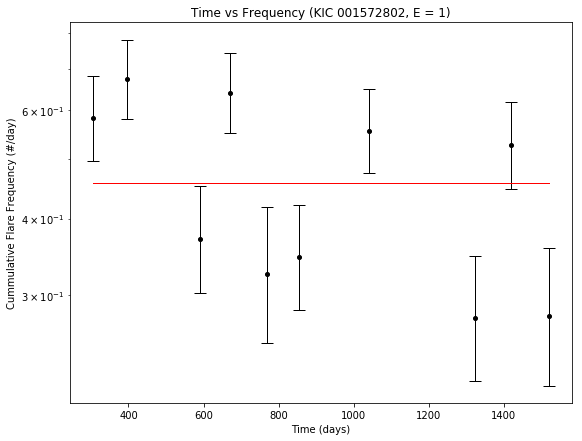

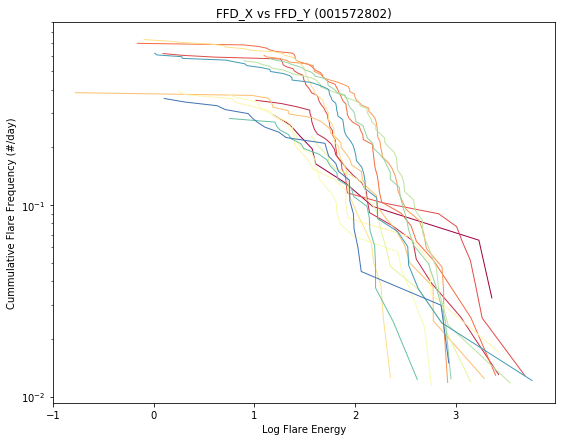

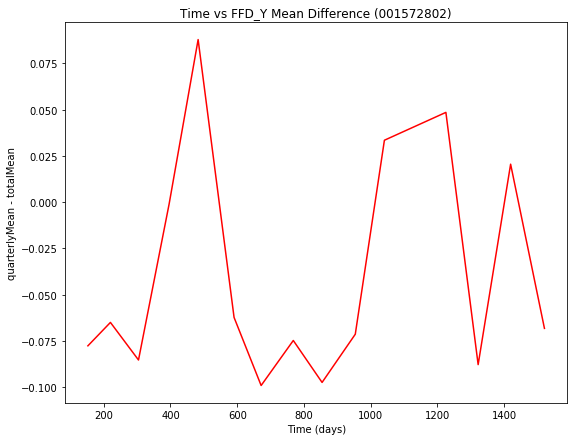

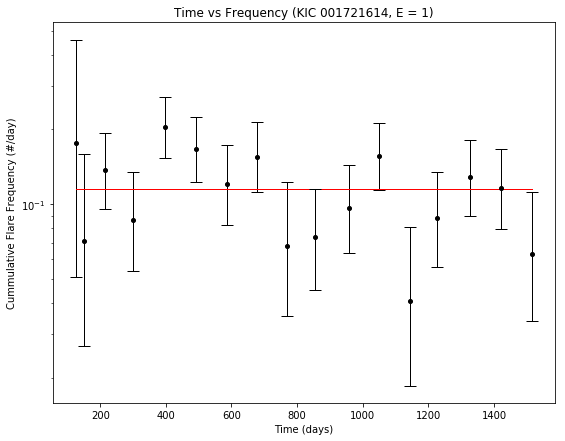

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


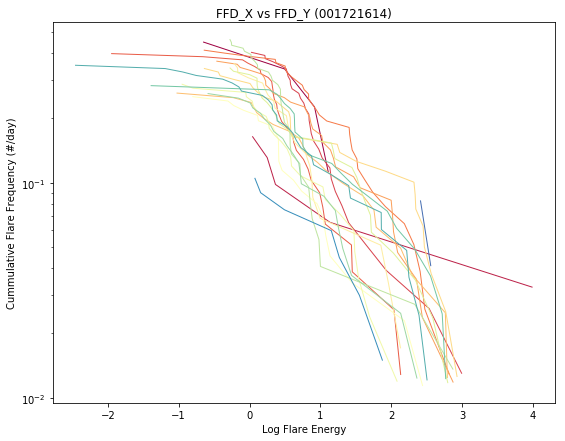

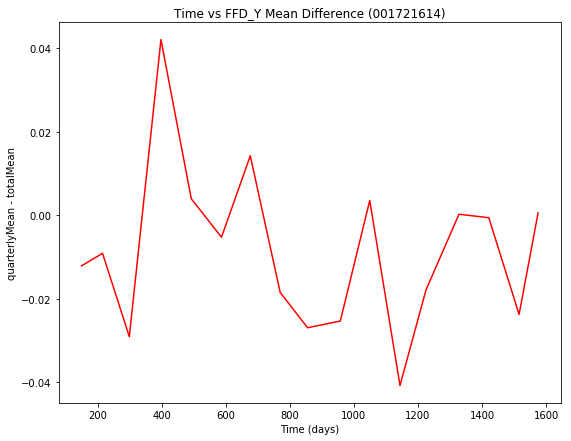

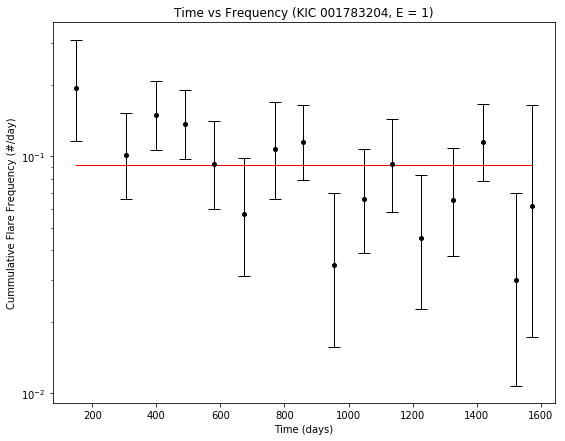

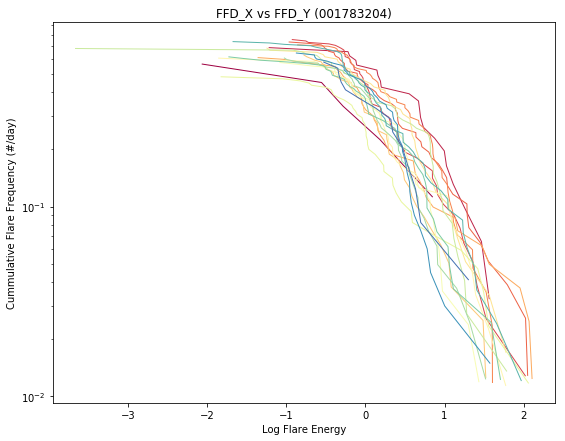

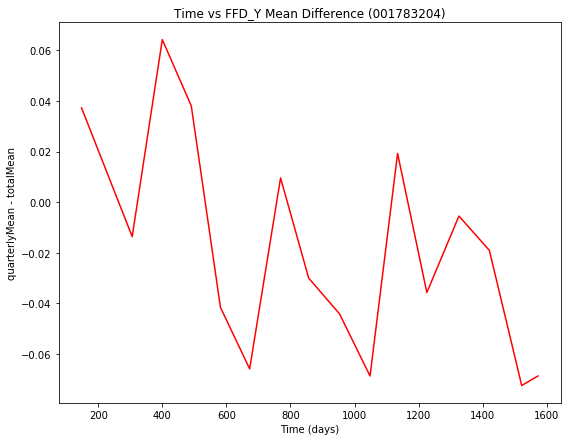

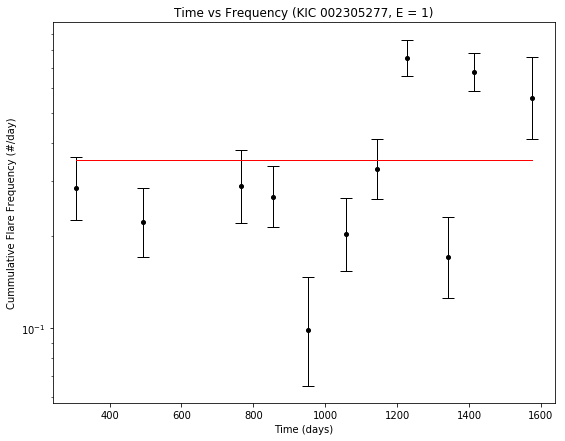

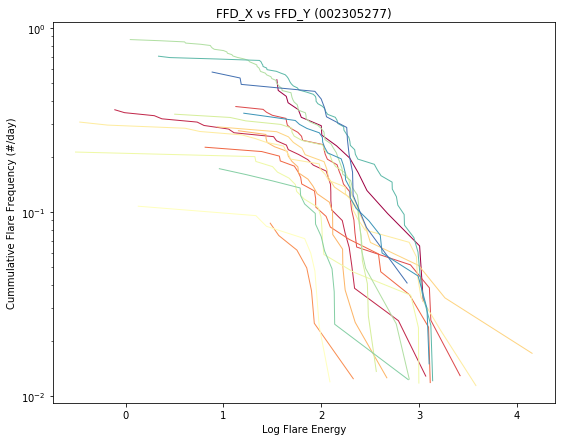

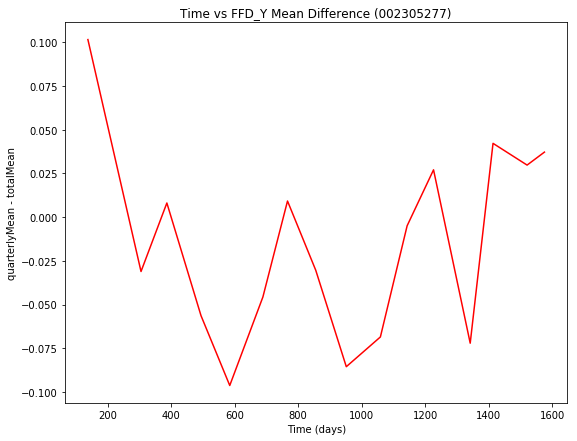

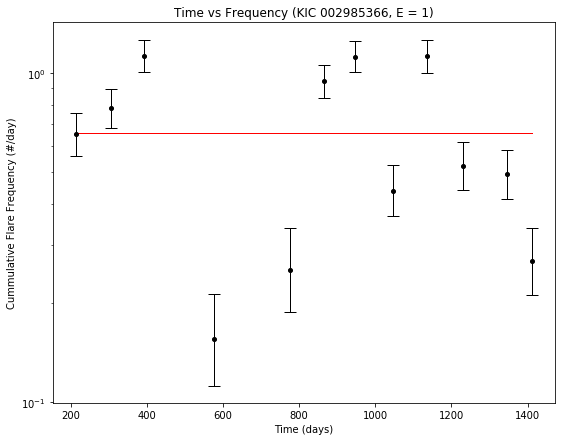

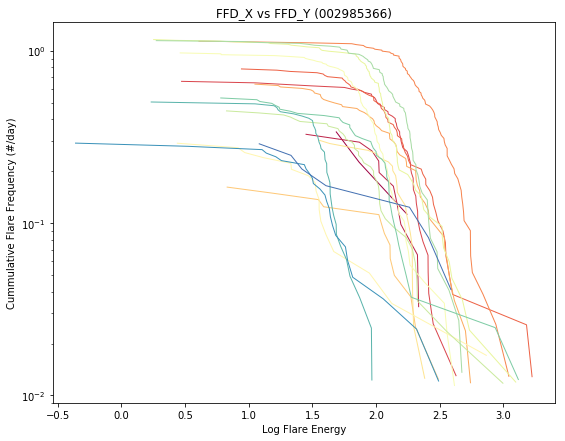

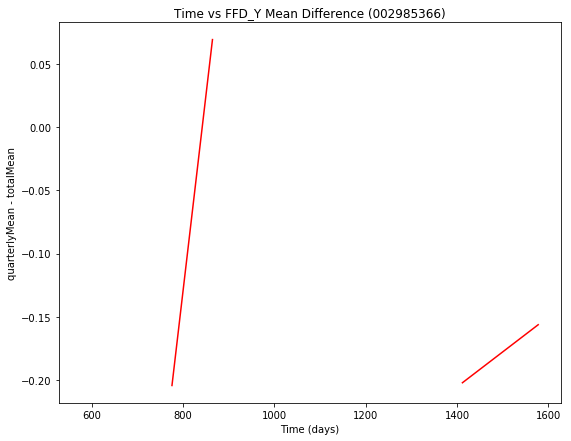

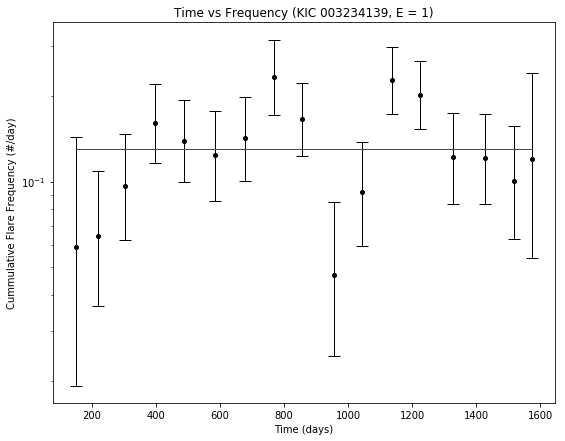

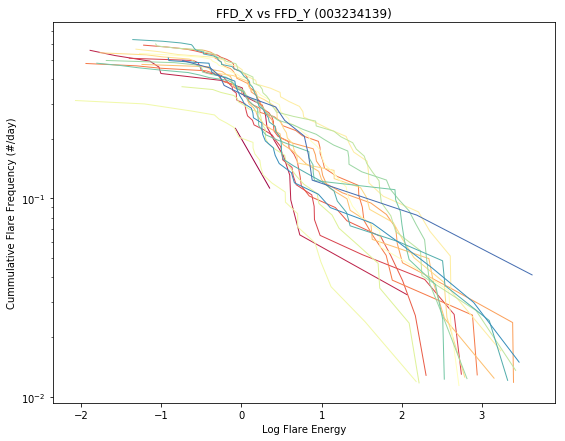

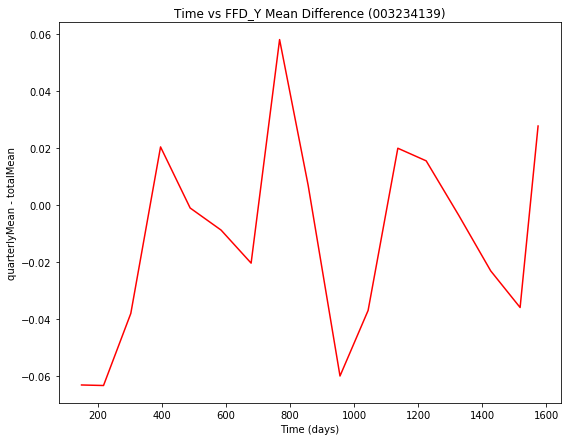

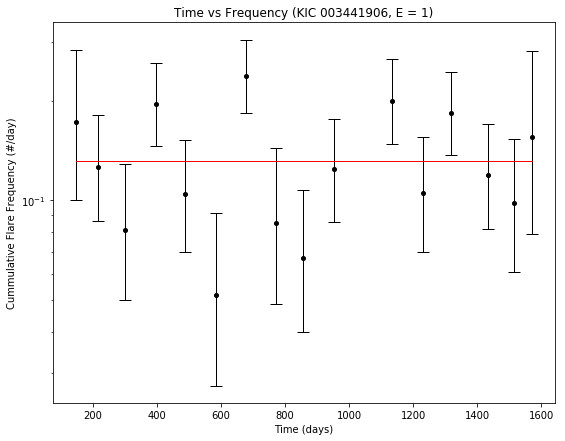

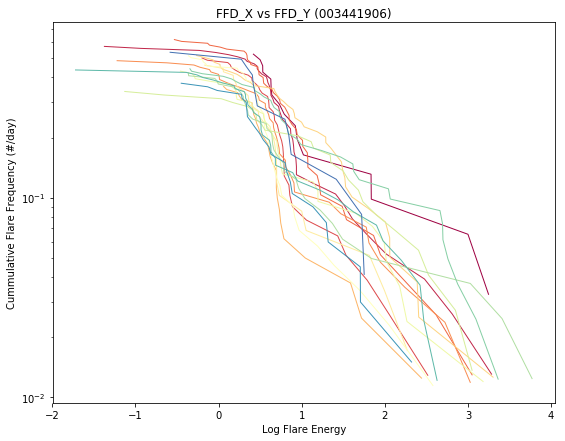

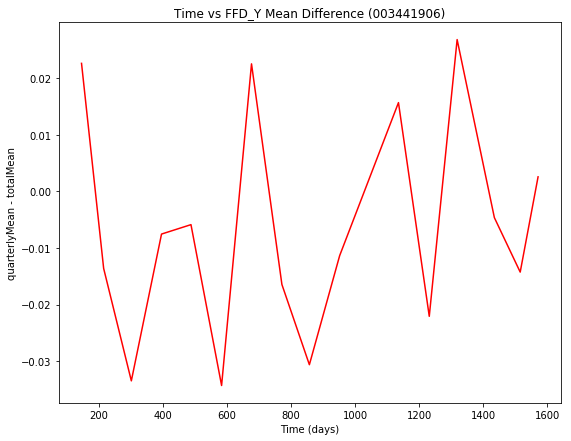

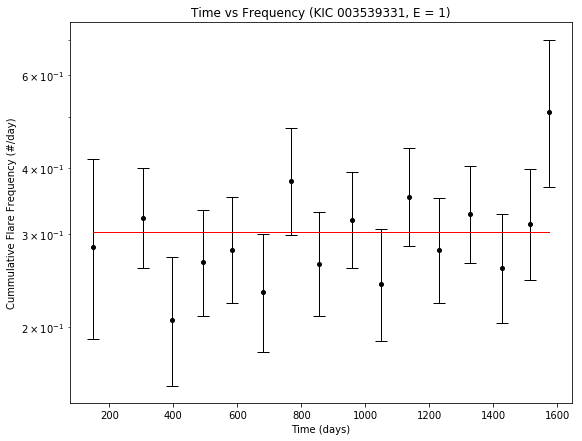

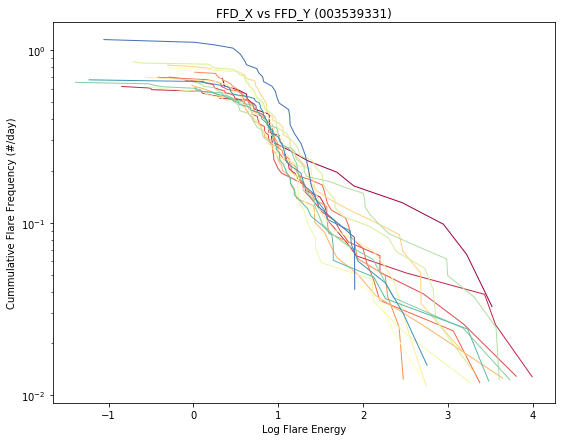

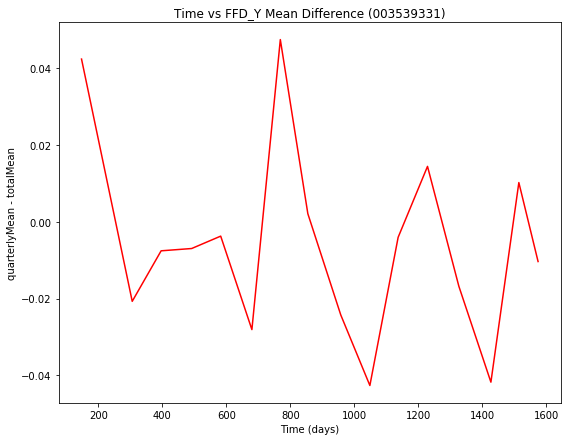

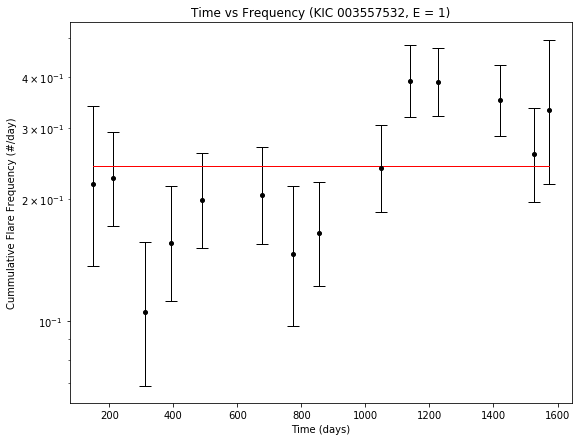

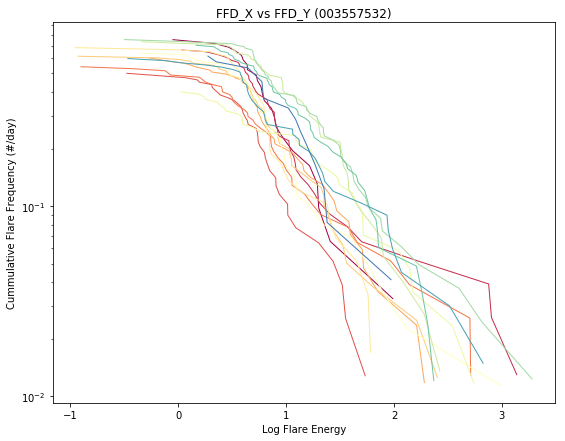

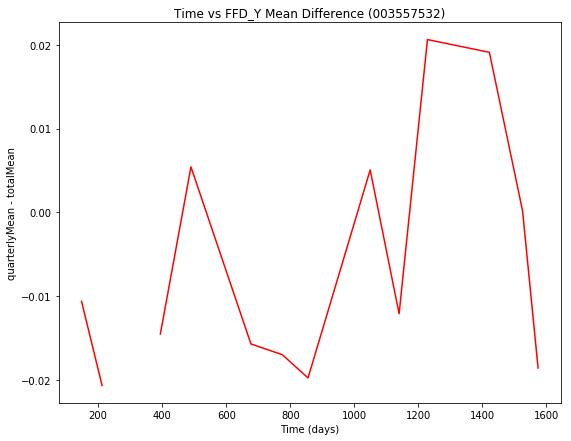

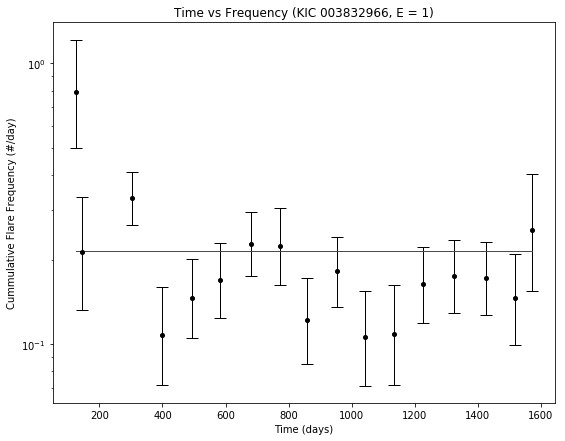

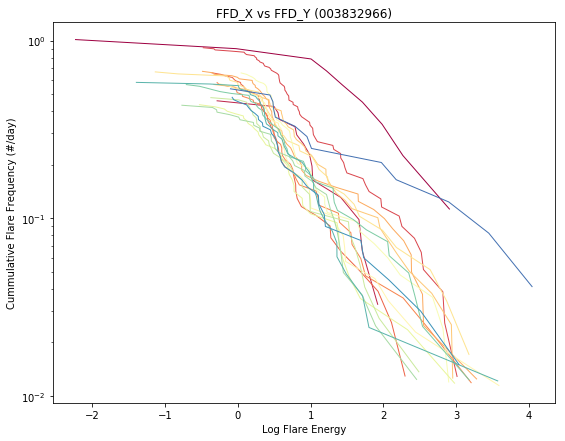

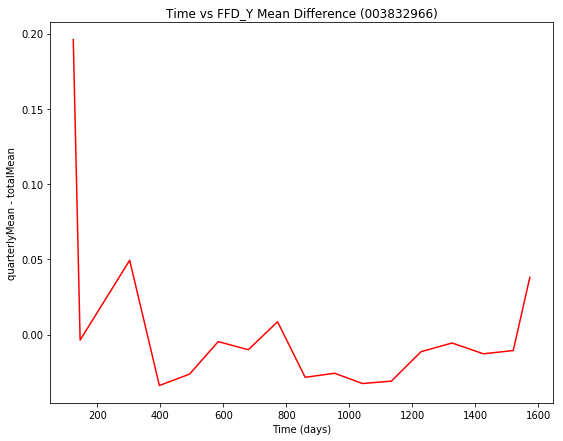

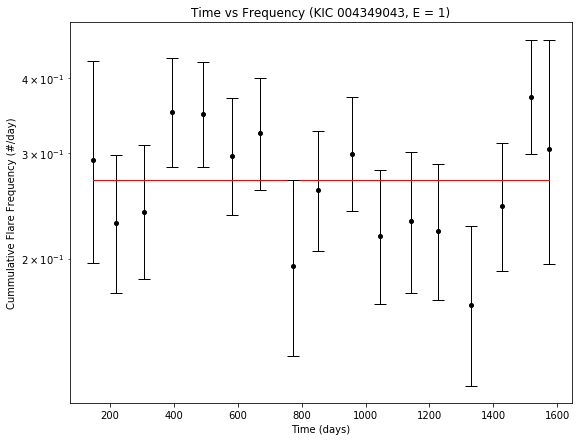

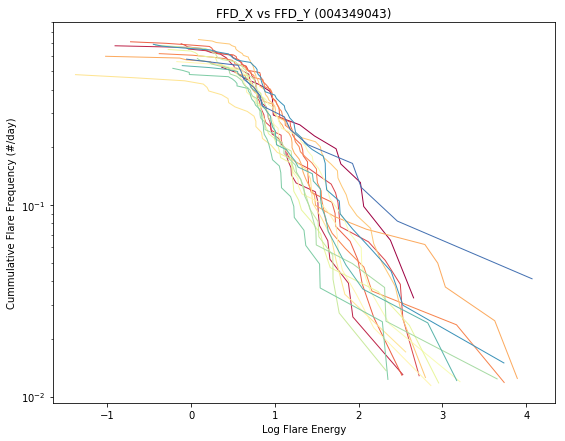

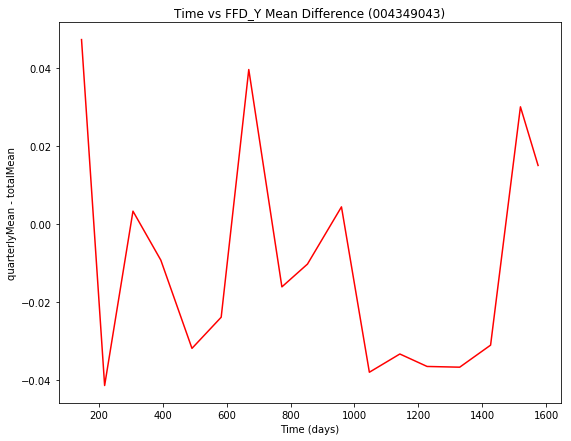

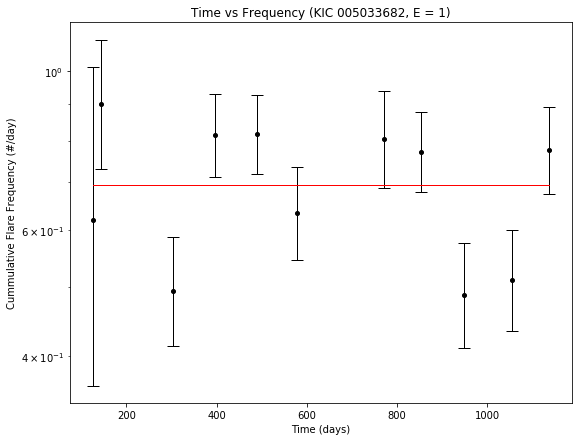

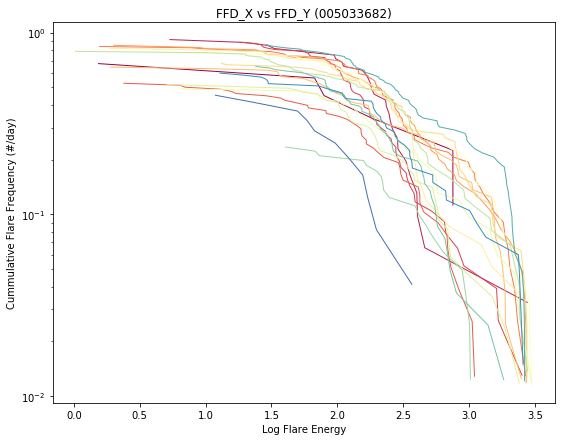

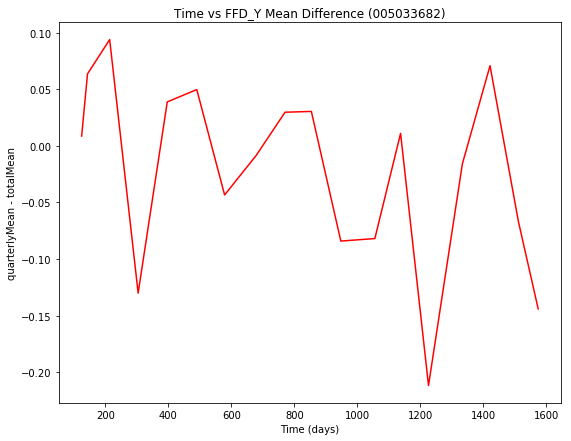

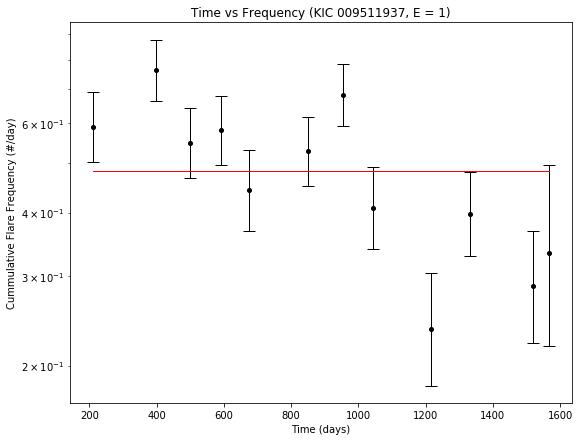

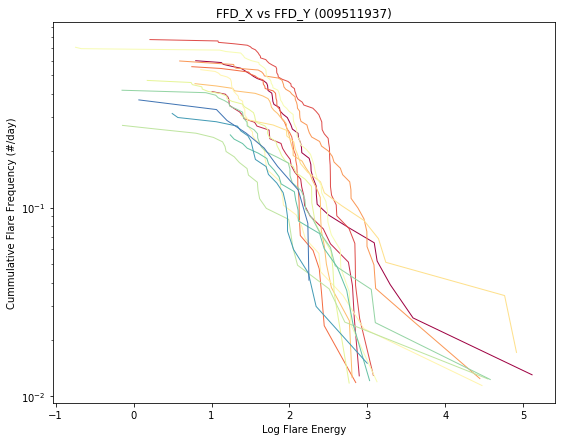

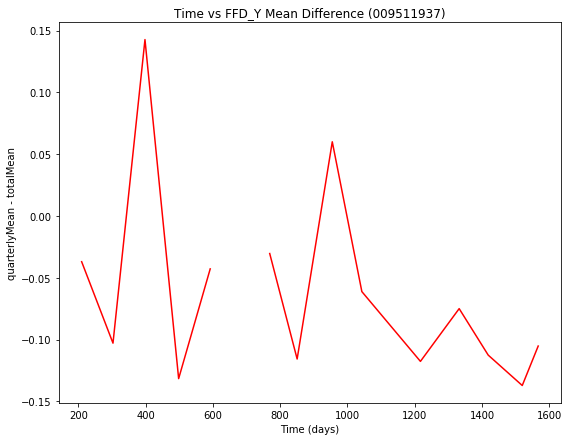

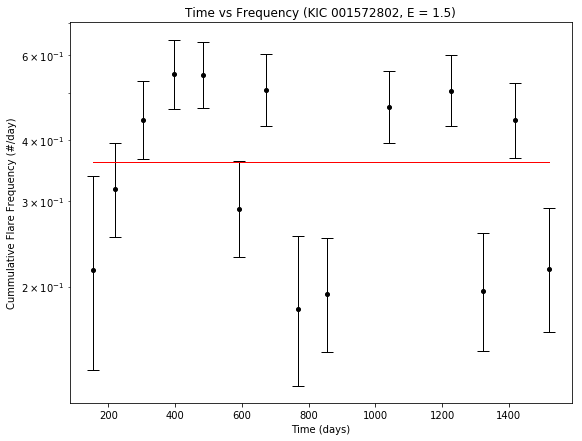

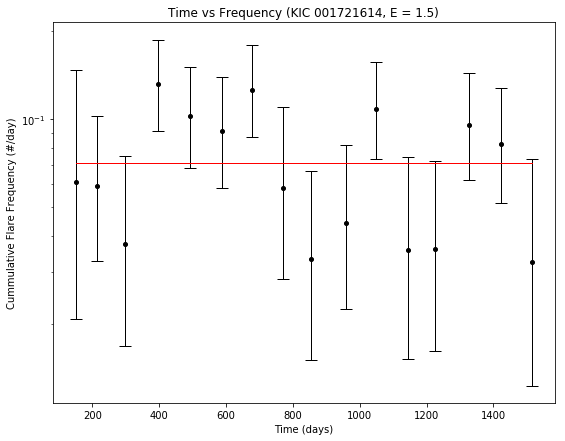

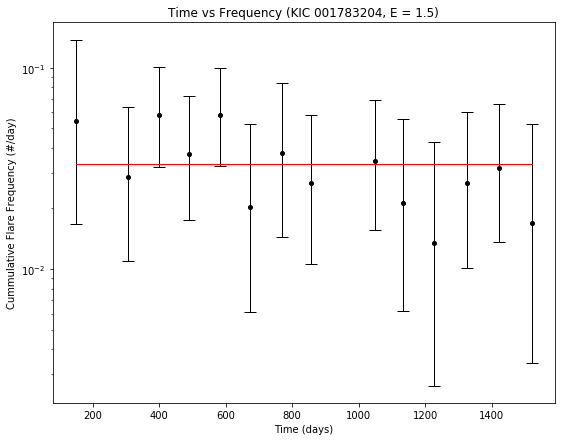

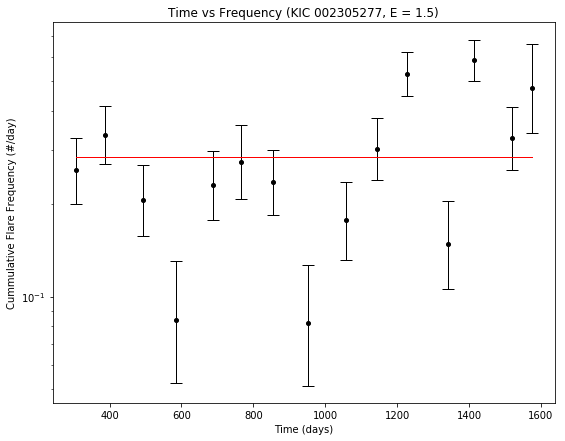

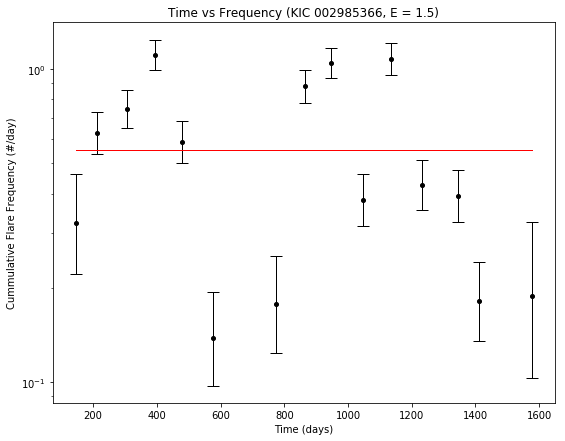

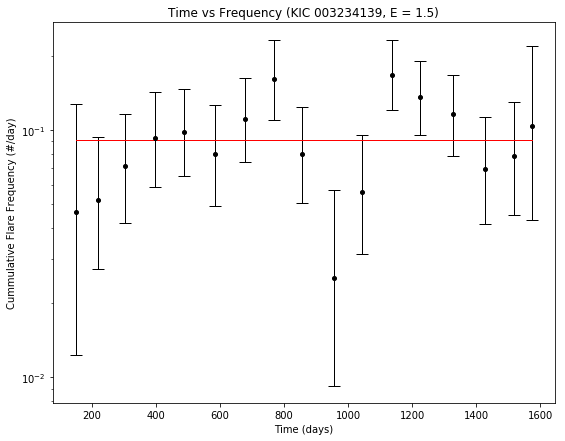

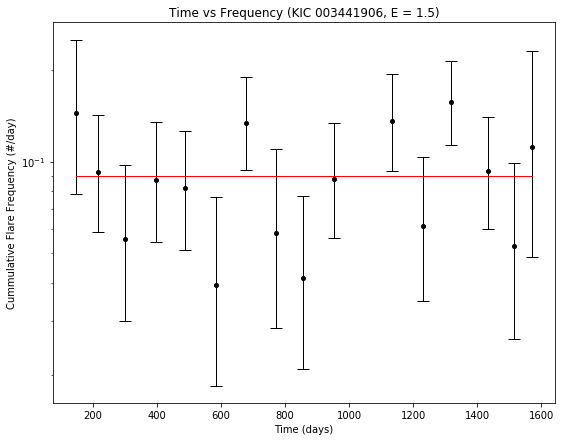

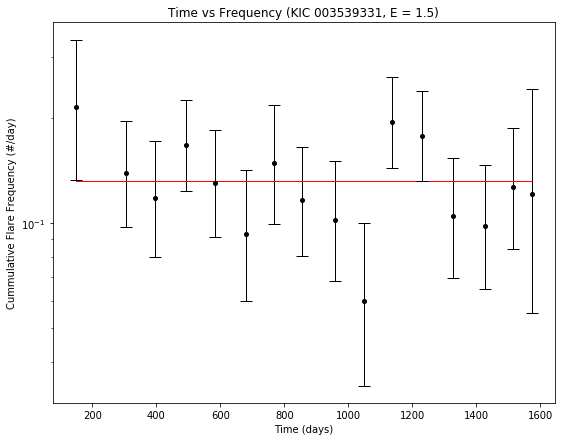

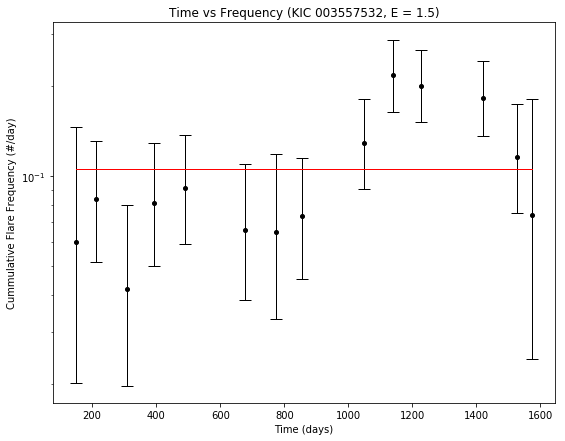

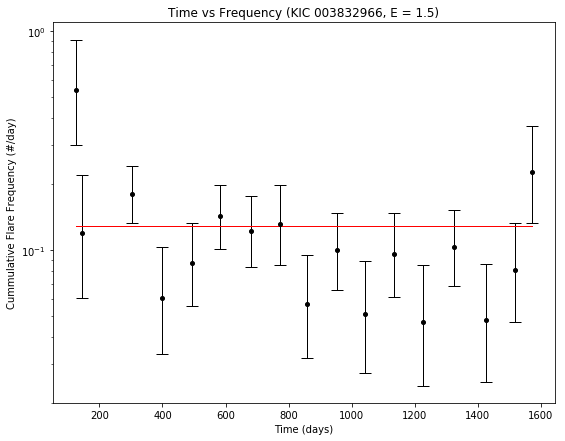

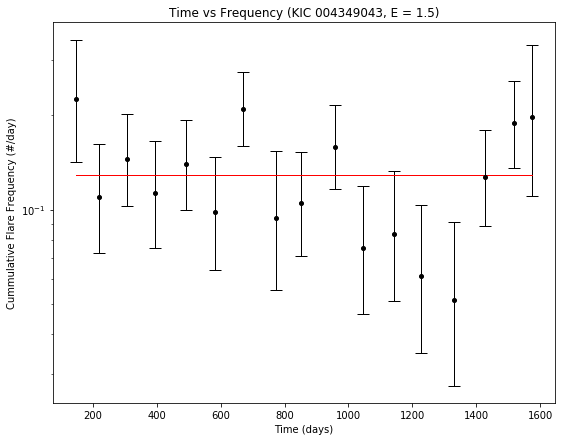

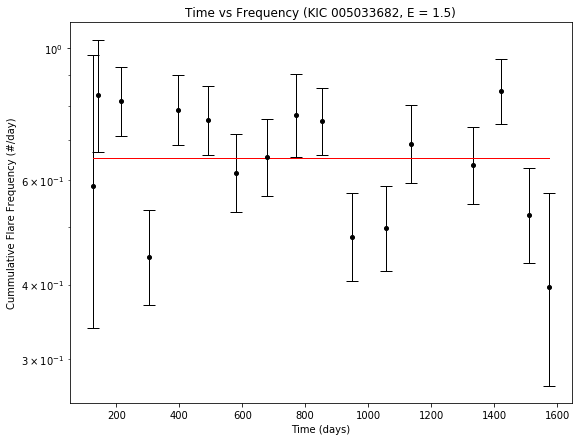

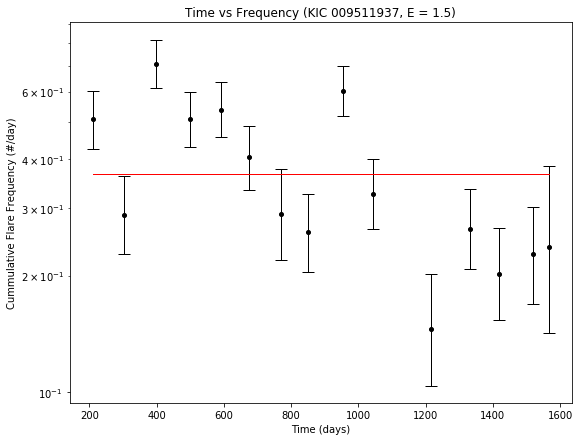

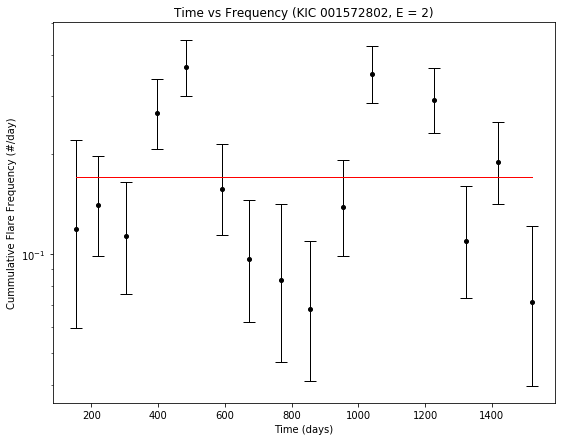

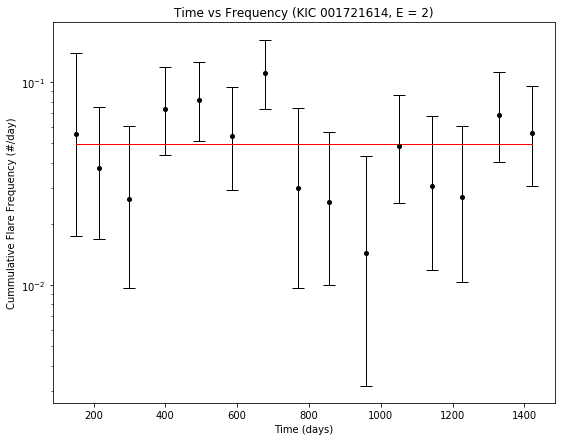

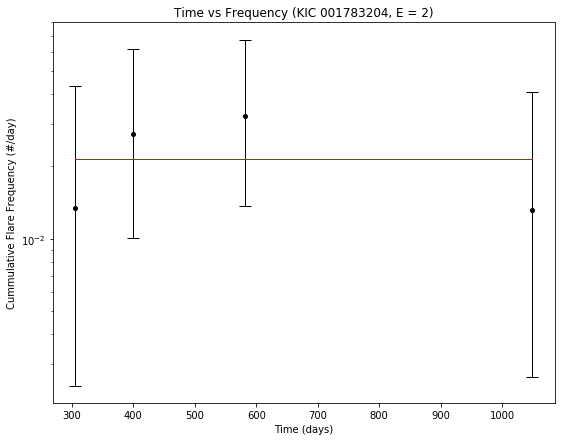

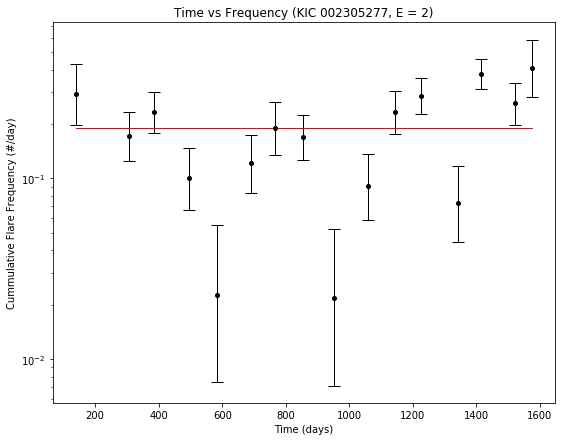

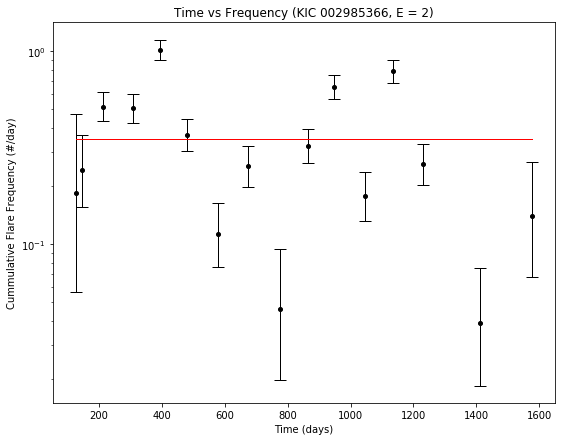

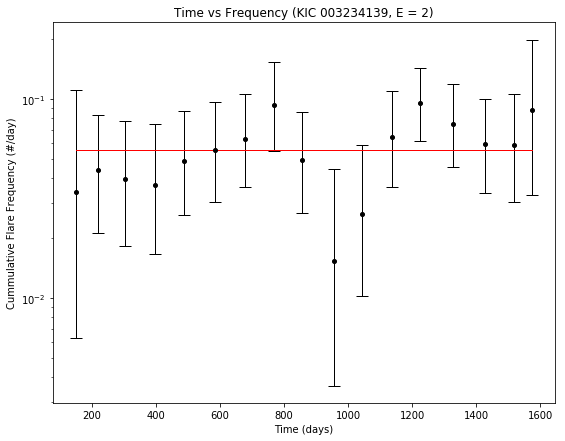

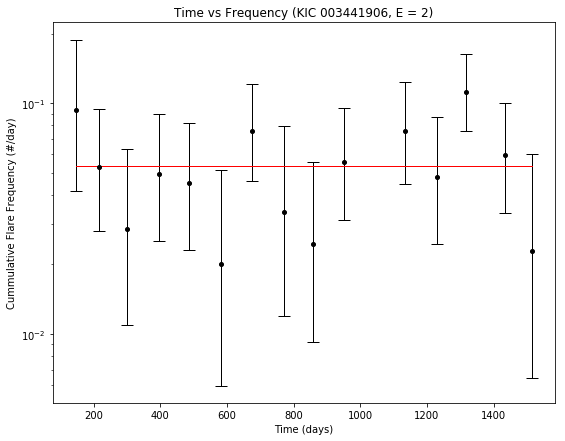

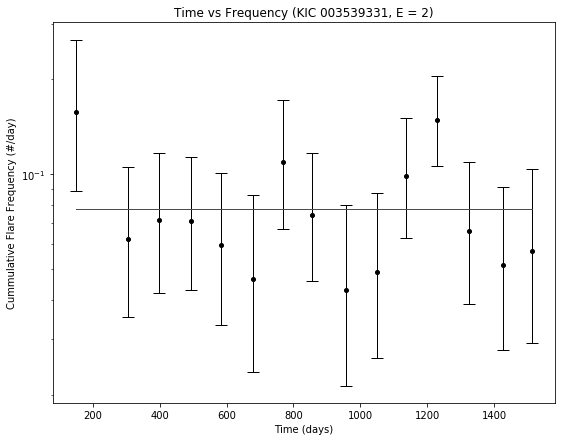

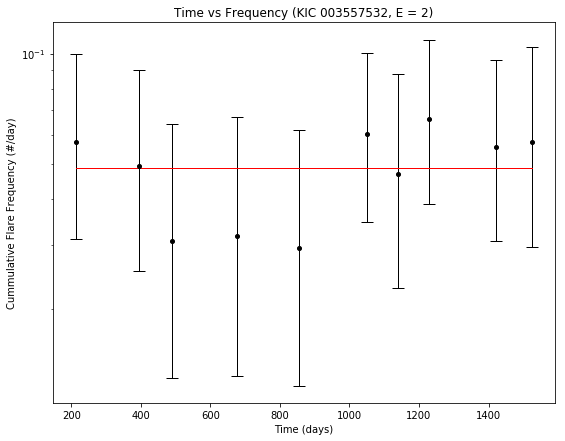

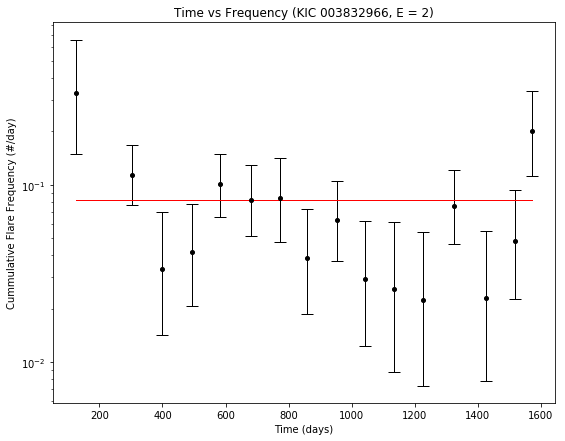

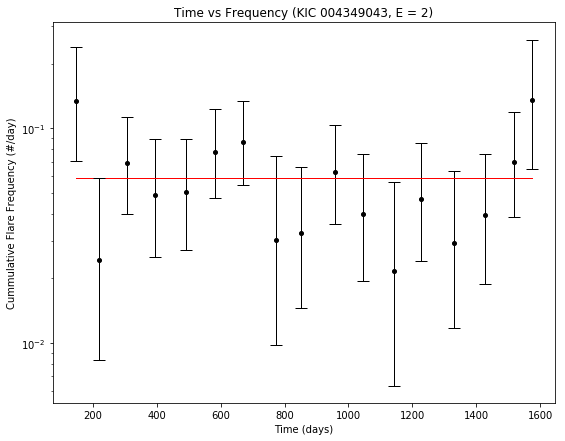

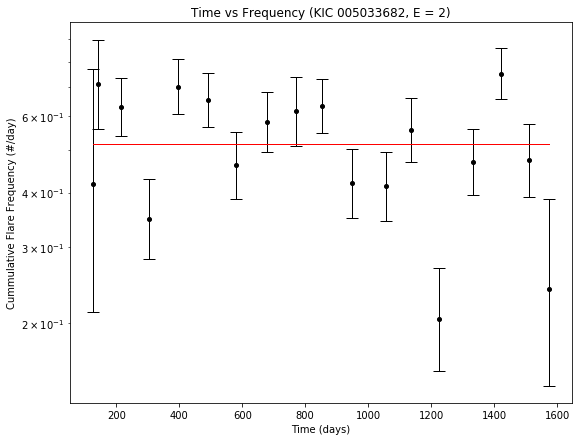

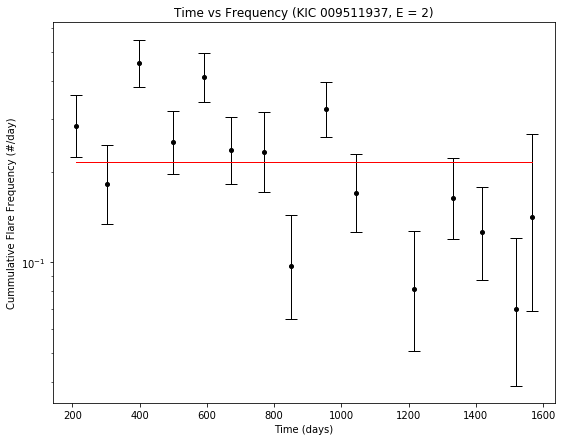

In [12]:
targetCount = getSize('KICs/targets.txt') #getting the number of targets using the target file
energyConstantList = [1, 1.5, 2] #a list containing all of the energies we'll plot TVF at
evfDir = 'energy_vs_frequency_plot'
tvfDir = 'time_vs_frequency_plot'
fitData = 'fit_data'

if not os.path.exists(evfDir): #searching for, and making the directories if they don't exist
    os.makedirs(evfDir)
if not os.path.exists(tvfDir):
    os.makedirs(tvfDir)
if not os.path.exists(fitData):
    os.makedirs(fitData)
    
for energyConstant in energyConstantList:
    
    targets = open('KICs/targets.txt', "r") # a file containing all the KICs we want to plot  
    fixedEnergy = energyConstant + EPOINT # the fixed energy value
    exportArray = np.zeros((targetCount + 2, 12), dtype='O') #what will become the data file containing all of our fit information
    exportArray[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','','',''] 
    exportArray[1] = ["#KIC", 'N', 'best degree', 'chiSquare', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0']
    targetIndex = 2
    
    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
        fileCount = len(files)

        plotTVF(KIC, files, fileCount, exportArray, fixedEnergy, targetIndex, show=True)

        if(energyConstant == energyConstantList[0]):
            plotEVF(KIC, files, fileCount,error=False, show=True, showMean=True, whole=True)

        targetIndex += 1

    #np.savetxt('fit_data/fit_data_for_E='+str(fixedEnergy)+'.txt', exportArray, fmt = '% 15s', delimiter=' ', newline='\n', header='', footer='', comments='# ')
    targets.close()